In [1]:
# Importing the necessary libraries.
import pandas as pd
import numpy as np
import gzip
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ti_network_file = '/home/hirak/Projects/CMSC828O/data/chilean_TI.txt'

In [4]:
df = pd.read_csv(ti_network_file,sep = '\t')

In [29]:
metadata_nodes = df[df.columns[:2].values]
metadata_nodes.columns = ['node_id', 'sp_name']

In [36]:
adj_df = df.loc[:,df.columns.isin(df.columns[2:])]

In [43]:
adj_mat = adj_df.values

In [45]:
G = nx.from_numpy_matrix(adj_mat)

In [47]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 106
Number of edges: 1361
Average degree:  25.6792


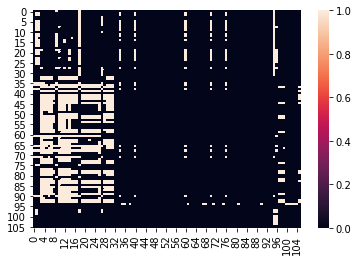

In [56]:
sns.heatmap(adj_mat)

In [220]:
num_classes, num_nodes = 4, G.number_of_nodes()
print(num_classes, num_nodes)
theta = np.zeros((num_classes,num_classes))
alpha = np.zeros(num_classes)
tau = np.zeros((num_nodes, num_classes))

4 106


In [214]:
from sklearn.cluster import SpectralClustering

In [215]:
sc = SpectralClustering(num_classes, affinity='precomputed', n_init=100)

In [216]:
sc.fit(adj_mat)

/home/hirak/miniconda2/envs/r-updated/lib/python3.6/site-packages/sklearn/utils/validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=4, n_init=100, n_jobs=None,
          n_neighbors=10, random_state=None)

In [221]:
# calculate tau
for i,j in enumerate(sc.labels_):
    tau[i,j] = 1

In [225]:
# calculate theta
for (i,j) in G.edges:
    q,r = sc.labels_[i], sc.labels_[j]
    theta[q,r] += 1

In [239]:
alpha = tau.sum(0)/ num_nodes

In [244]:
# E step
from tqdm import tqdm_notebook as tqdm
import time
eps = 1e-3
L_old = 0
L_vec = []
for step in range(10):
    start = time.time()
    # print('step ',step)
    tau_new_log = np.zeros((num_nodes, num_classes))
    for i in range(num_nodes):
        for q in range(num_classes):
            tau_new_log[i,q] = 0
            for j in range(num_nodes): 
                if(i != j):
                    # create prob
                    theta_q_tmp = theta[q,] + eps
                    theta_q_tmp = theta_q_tmp  / theta_q_tmp.sum()
                    theta_q_col = theta[:,q] + eps
                    theta_q_col = theta_q_col / theta_q_col.sum()
                    
                    b_mat = (
                        adj_mat[i,j] * np.log( theta_q_tmp ) +
                        (1 - adj_mat[i,j]) * (np.log(1 - theta_q_tmp )) +
                        adj_mat[j,i] * np.log( theta_q_col ) +
                        (1 - adj_mat[i,j]) * (np.log( 1 - theta_q_col ))
                    )
                    #print(b_mat.shape, tau[j,].shape)

                    tau_new_log[i,q] += np.dot(tau[j,],b_mat)
            tau_new_log[i,q] += np.log(alpha[q])
            
    tau_new = np.exp(tau_new_log)
    tau = tau_new.copy()
    tau = tau / tau.sum(axis=1, keepdims=1)

    # M step
    # Calculate alpha
    alpha = tau.sum(axis = 0) / num_nodes
    alpha = alpha / alpha.sum()
    # Calculate theta
    for q in range(num_classes):
        for r in range(num_classes):
            num = 0
            denom = 0
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if ( i != j):
                        num += adj_mat[i,j] * tau[i,q] * tau[j,r]
                        denom +=  tau[i,q] * tau[j,r]
            theta[q,r] = num / denom
        theta[q,] = theta[q,] / theta[q,].sum()

    L = np.dot(tau.sum(axis = 0), np.log(alpha)) 
    for i in range(num_nodes):
        for j in range(num_nodes):
            if( i != j ):
                for q in range(num_classes):
                    # make theta prob distribution
                    theta_q_tmp = theta[q,] + eps
                    tmp_q = theta_q_tmp / theta_q_tmp.sum()
                    for r in range(num_classes):
                        L += (0.5) * (
                            tau[i,q] * tau[j,r] *
                            (adj_mat[i,j] * np.log(theta[q,r]) +
                            (1 - adj_mat[i,j]) * np.log(1 - theta[q,r]))
                        )

    end = time.time()
    L_vec += [L]
    print('diff...{} elapsed time...{}'.format(L - L_old, end - start))
    L_old = L

diff...-4278.70605714161 elapsed time...4.5385048389434814
diff...3.404701520164963 elapsed time...4.318186521530151
diff...-4402.380707804865 elapsed time...4.380695581436157
diff...6602.303640922493 elapsed time...4.382697582244873
diff...1.7714705849107304 elapsed time...4.381289482116699
diff...0.7135666350736756 elapsed time...4.276834726333618
diff...-2.4572600925225743 elapsed time...4.363891839981079
diff...0.39290804828578985 elapsed time...4.3955512046813965
diff...-57.838127809106936 elapsed time...4.315672874450684
diff...58.286187923204125 elapsed time...4.311520099639893


In [238]:
1e-3

0.001

In [234]:
np.ep

AttributeError: module 'numpy' has no attribute 'eps'